# Project Title
### Data Engineering Capstone Project

#### Project Summary
-----

This projects goal is to create an ETL pipeline that moves the US Immigration data including some supplementary datasets such as the data on airport codes, U.S. city demographics and city temperature data to a database. This database will then be used to query data to answer questions such as, do people tend to migrate to places that are warmer?

----

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
from pyspark.sql import SparkSession, SQLContext, GroupedData
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructField
from pyspark.sql.types import StructType
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import avg
from pyspark.sql import functions as F
import datetime, time
from datetime import datetime, timedelta
from pyspark.sql import types as T
from glob import glob
import pandas as pd
import numpy as np
import re
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
import assess_data as assess
import clean_data as clean
import create_schema as schema
import create_tables as tables

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
config("spark.sql.broadcastTimeout", "36000").\
spark = SparkSession.builder.getOrCreate()
spark

### Step 1: Scope the Project and Gather Data

#### Scope 
This projects goal is to complement the US immigration dataset with demographic and temperature data in order to have a richer analysis of the immigration data.

#### Describe and Gather Data 

1. I94 Immigration Dataset
- this dataset comes from the US National Tourism and Trade Office
2. World Temperature Dataset
- this dataset comes from kaggle 
3. U.S. City Demographic Dataset
- this dataset comes from opendatasoft

#### I94 Immigration Data

The data stems from the US National Tourism and Trade Office. Every person that arrived to the US, had to fill out a form. One form was th Customs and Border Protection I-94 Arrival and Departure Form, the I-94W Non-immigrant Visa Waiver Arrival/Departure Form. The dataset illustrates that data.

In [3]:
# Read in spark
immigration_spark =spark.read.load('./sas_data')

In [3]:
#Read in pandas
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_pd = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")

In [5]:
#show top five row
immigration_pd.head(5)

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,NaN,NaN,...,U,NaN,1979.0,10282016,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,NaN,1991.0,D/S,M,NaN,NaN,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,NaN,M,1961.0,09302016,M,NaN,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,1988.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,NaN,M,2012.0,09302016,NaN,NaN,AA,9.246846e+10,00199,B2


In [6]:
#print dataframe's schema
immigration_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [7]:
#show five rows
immigration_spark.show(n=5)

+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|    cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+---------+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|5748517.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     CA|20582.0|  40.0|    1.0|  1.0|20160430|     SYD| null|      G|      O|   null|      M| 1976.0|10292016|     F|  null|     QF|9.495387003E10|00011|      B1|
|5748518.0|2016.0|   4.0| 245.0| 438.0|    LOS|20574.0|    1.0|     NV|20591.0|  32.0|    1.0|  

In [8]:
#count total records of immigration data
print('{:,}'.format(immigration_spark.count()))

3,096,313


#### Data Dictionary

Feature  |Description
:--------|:-----------
cicid    |Unique ID
i94yr    |year
i94mon   |month
i94cit   |3 digit code immigrant country of birth
i94res   |3 digit code immigrant country of residence
i94port  |Port of admission
arrdate  |Arrival Date in USA
i94mode  |Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
i94addr  |USA State arrival
depdate  |Departure Date from USA
i94bir   |Age of Respondent in Years
i94visa  |Visa codes collapsed into 3 categories
count    |Field used Summary Statistics
dtadfile |Character Date Field - Date added to I-94 Files
visapost |Department of State where Visa was issued
occup    |Occupation that will be performed in USA
entdepa  |Arrival Flag - admitted or paroled into the USA
entdepd  |Departure Flag - Departed lost I-94 or is deceased
entdepu  |Update Flag - Either apprehended overstayed adjusted to perm residence
matflag  |Match flag - Match of arrival and departure records
biryear  |4 digit year of birth
dtaddto  |Character Date Field - Date to which admitted to USA (allowed to stay until)
gender   |Non-immigrant sex
insnum   |INS number
airline  |Airline used to arrive in USA
admnum   |Admission Number
fltno    |Flight number of Airline used to arrive in USA
visatype |Class of admission legally admitting the non-immigrant to temporarily stay in USA


#### World Temperature Data

The dataset stems from Kaggle and the US National Tourism and Trade Office respectively. It illustrates the global land temperatures on a city level.

In [4]:
#read in spark
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_spark = spark.read.csv(fname, header=True, inferSchema=True)

In [4]:
#read in pandas
fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_pd = pd.read_csv(fname)

In [11]:
#show top five rows
temperature_pd.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [12]:
#print dataframe's schema
temperature_spark.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



In [13]:
#show five rows using spark
temperature_spark.show(n=5)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



In [14]:
#count total records of temperature data
print('{:,}'.format(temperature_spark.count()))

8,599,212


#### Data Dictionary

    

Feature                       |Description
:-----------------------------|:-----------
dt                            |Date
AverageTemperature            |Average temperature in celsius
AverageTemperatureUncertainty |95% confidence interval around average temperature
City                          |Name of city
Country                       |Name of country
Latitude                      |Latitude of city
Longitude                     |Longitude of city


#### U.S. City Demographic Data

The data stems from opendatasoft and contains information around the US cities' demographics. The data holds information on US cities such as size, gender, race amongst other.

In [5]:
#read in spark
fname = "./us-cities-demographics.csv"
demographics_spark = spark.read.csv(fname, header=True, inferSchema=True, sep=';')

In [5]:
#read in pandas
demographics_pd = pd.read_csv("us-cities-demographics.csv", sep=';')

In [17]:
#show top five rows
demographics_pd.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [18]:
#print dataframe's schema
demographics_spark.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



In [19]:
#show five rows using spark
demographics_spark.show(n=5)

+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|        State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+-------------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|   Silver Spring|     Maryland|      33.8|          40601|            41862|           82463|              1562|       30908|                   2.6|        MD|  Hispanic or Latino|25924|
|          Quincy|Massachusetts|      41.0|          44129|            49500|           93629|              4147|       32935|                  2.39|        MA|               White|58723|
|          Hoover|      Alabama|      38.5|          38040| 

#### Data Dictionary

Feature                       | Description
:-----------------------------|:-----------
City |City Name
State |US State of City
Median Age |Median Population Age
Male Population |Total Male Population
Female Population |Total Female Population
Total Population |Total Population
Number of Veterans |# of veterans living in city
Foreign-born |Number of residents who were not born in city
Average Household Size |Average size of houses in city
State Code |State Code
Race |Race class
Count |# of Individuals in each Race


In [20]:
#count total records of demographic data
print('{:,}'.format(demographics_spark.count()))

2,891


#### Airport Codes Dataset

A dataset with airport codes and cities.

In [6]:
#read in spark
airport_codes = "./airport-codes_csv.csv"
airport_codes_spark = spark.read.csv(airport_codes, header=True, inferSchema=True)

In [6]:
#read in pandas
airport_codes_pd = pd.read_csv("airport-codes_csv.csv")

In [23]:
#show top five rows
airport_codes_pd.head(5)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [24]:
#print dataframes schema
airport_codes_spark.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [25]:
#print 5 rows using spark
airport_codes_spark.show(5)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
| 00AK|small_airport|        Lowell Field|         450|       NA|         US|     US-AK|Anchor Point|    00AK|     null|      00AK|-151.695999146, 5...|
| 00AL|small_airport|        Epps Airpark|         820|       NA|         US|     

In [26]:
#count total records of airport_codes data
print('{:,}'.format(airport_codes_spark.count()))

55,075


#### Data Dictionary

    
Feature       |Description
:-------------|:-----------
ident         |Unique Identifier (ID)
type          |Airport Type
name          |Airport Name
elevation_ft  |Airport Altitude
continent     |Continent
iso_country   |ISO Code of the Airport's Country
iso_region    |ISO Code for the Airport's Region
municipality  |City or Municipality where the Airport is Located
gps_code      |Airport GPS Code
iata_code     |Airport IATA Code
local_code    |Airport local code
coordinates   |Airport coordinates


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

### Immigration Data

In [27]:
#assess general information on immigration data
assess.general_dataframe_info(immigration_pd)

-----General Information on the Dataframe-----
Dataframe Shape: (3096313, 28) 

Column Headers: ['cicid', 'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'dtadfile', 'visapost', 'occup', 'entdepa', 'entdepd', 'entdepu', 'matflag', 'biryear', 'dtaddto', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype'] 

cicid       float64
i94yr       float64
i94mon      float64
i94cit      float64
i94res      float64
i94port      object
arrdate     float64
i94mode     float64
i94addr      object
depdate     float64
i94bir      float64
i94visa     float64
count       float64
dtadfile     object
visapost     object
occup        object
entdepa      object
entdepd      object
entdepu      object
matflag      object
biryear     float64
dtaddto      object
gender       object
insnum       object
airline      object
admnum      float64
fltno        object
visatype     object
dtype: object


As can be inferred from the above general analysis, the dataframe is rather large with over 3 million rows and 28 columns. The majority of data types are object and a few are float int

In [28]:
#assess unique and missing values
assess.dataframe_report(immigration_pd)

Unique Values
cicid has 3096313 unique values
i94yr has 1 unique values
i94mon has 1 unique values
i94cit has 243 unique values
i94res has 229 unique values
i94port has 299 unique values
arrdate has 30 unique values
i94mode has 5 unique values
i94addr has 459 unique values
depdate has 236 unique values
i94bir has 113 unique values
i94visa has 3 unique values
count has 1 unique values
dtadfile has 118 unique values
visapost has 531 unique values
occup has 112 unique values
entdepa has 14 unique values
entdepd has 13 unique values
entdepu has 3 unique values
matflag has 2 unique values
biryear has 113 unique values
dtaddto has 778 unique values
gender has 5 unique values
insnum has 1914 unique values
airline has 535 unique values
admnum has 3075579 unique values
fltno has 7153 unique values
visatype has 17 unique values

--------------------------------------------------------------

Missing Values
Features that contain missing values:

239 is missing in i94mode, 0.007718857880324115%.



Concluding from the above, we see that more than 90% of data is missing in occup, entdepu and insnum

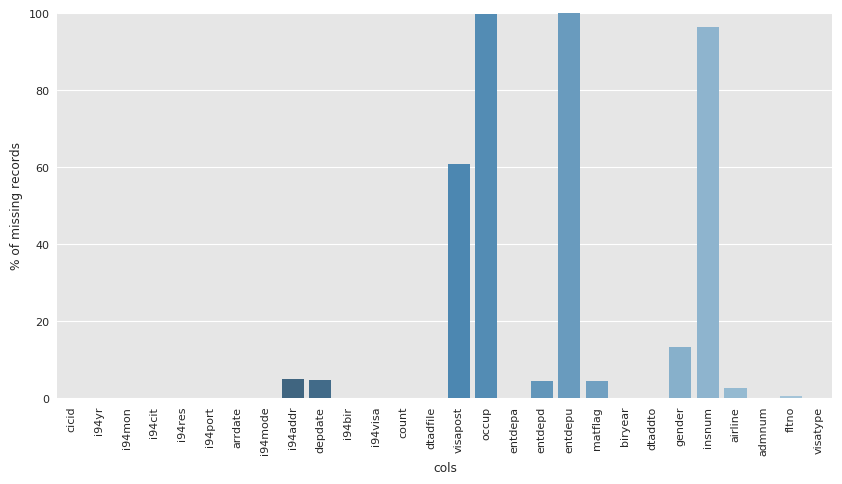

In [29]:
#visualise the missing values
assess.visualise_missing_records(immigration_pd)

The above graph visualises that many records are missing for visapost, entdepu and insnum and a few more variables in other columns

### Temperature Data

In [30]:
#assess general information on immigration data
assess.general_dataframe_info(temperature_pd)

-----General Information on the Dataframe-----
Dataframe Shape: (8599212, 7) 

Column Headers: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude'] 

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object


The above dataframe holds more than 8.5 million rows and 7 columns. The dataset contains if 2 floats and 5 object data types.

In [31]:
#assess unique and missing values
assess.dataframe_report(temperature_pd)

Unique Values
dt has 3239 unique values
AverageTemperature has 111995 unique values
AverageTemperatureUncertainty has 10903 unique values
City has 3448 unique values
Country has 159 unique values
Latitude has 73 unique values
Longitude has 1227 unique values

--------------------------------------------------------------

Missing Values
Features that contain missing values:

364130 is missing in AverageTemperature, 4.234457761943768%.

364130 is missing in AverageTemperatureUncertainty, 4.234457761943768%.


Only a small portion of records are missing in two columns. Overall, the dataset appears to be complete.

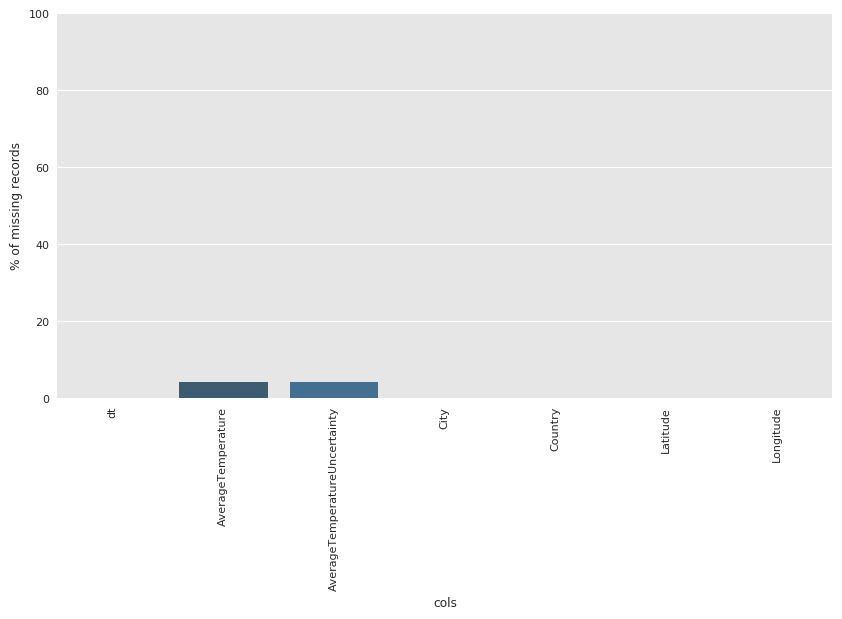

In [32]:
#visualise the missing values
assess.visualise_missing_records(temperature_pd)

The visual proves that only a fraction of data is missing in two columns.

### Demographic Data

In [33]:
#assess general information on demographic data
assess.general_dataframe_info(demographics_pd)

-----General Information on the Dataframe-----
Dataframe Shape: (2891, 12) 

Column Headers: ['City', 'State', 'Median Age', 'Male Population', 'Female Population', 'Total Population', 'Number of Veterans', 'Foreign-born', 'Average Household Size', 'State Code', 'Race', 'Count'] 

City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object


The above dataframe is rather small, particularly looking at the rather large datasets above. Most data are numbers and a couple of objects.

In [34]:
#assess unique and missing values
assess.dataframe_report(demographics_pd)

Unique Values
City has 567 unique values
State has 49 unique values
Median Age has 180 unique values
Male Population has 594 unique values
Female Population has 595 unique values
Total Population has 594 unique values
Number of Veterans has 578 unique values
Foreign-born has 588 unique values
Average Household Size has 162 unique values
State Code has 49 unique values
Race has 5 unique values
Count has 2785 unique values

--------------------------------------------------------------

Missing Values
Features that contain missing values:

3 is missing in Male Population, 0.10377032168799723%.

3 is missing in Female Population, 0.10377032168799723%.

13 is missing in Number of Veterans, 0.44967139398132133%.

13 is missing in Foreign-born, 0.44967139398132133%.

16 is missing in Average Household Size, 0.5534417156693185%.


A very small portion of the data is missing. We see that the majority of data is missing >0.5% of data per column.

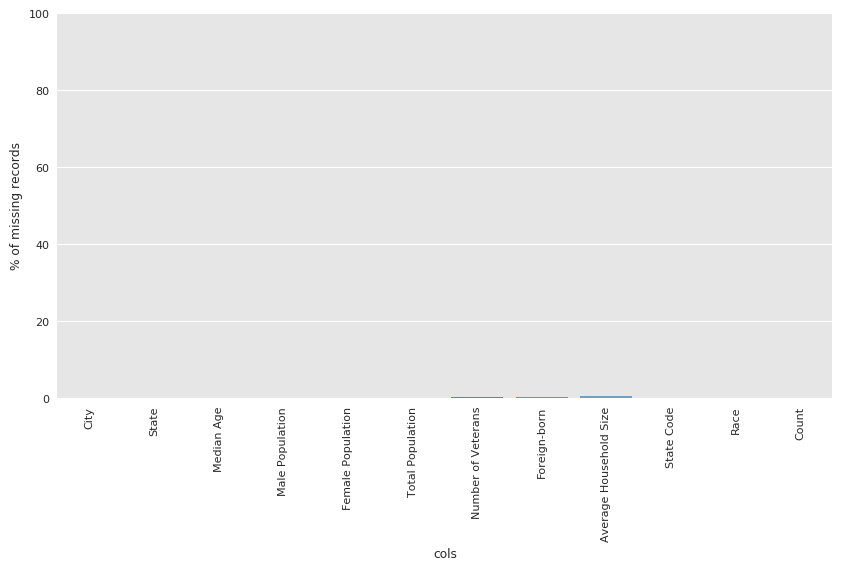

In [35]:
#visualise the missing values
assess.visualise_missing_records(demographics_pd)

Again, the visual confirms that only a small portion of data is missing

### Airport Codes Data

In [36]:
#assess general information on immigration data
assess.general_dataframe_info(airport_codes_pd)

-----General Information on the Dataframe-----
Dataframe Shape: (55075, 12) 

Column Headers: ['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country', 'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code', 'coordinates'] 

ident            object
type             object
name             object
elevation_ft    float64
continent        object
iso_country      object
iso_region       object
municipality     object
gps_code         object
iata_code        object
local_code       object
coordinates      object
dtype: object


most data are objects with only one number

In [37]:
#assess unique and missing values
assess.dataframe_report(airport_codes_pd)

Unique Values
ident has 55075 unique values
type has 7 unique values
name has 52144 unique values
elevation_ft has 5450 unique values
continent has 7 unique values
iso_country has 244 unique values
iso_region has 2810 unique values
municipality has 27134 unique values
gps_code has 40851 unique values
iata_code has 9043 unique values
local_code has 27437 unique values
coordinates has 54874 unique values

--------------------------------------------------------------

Missing Values
Features that contain missing values:

7006 is missing in elevation_ft, 12.7208352246936%.

27719 is missing in continent, 50.32955061280072%.

247 is missing in iso_country, 0.448479346345892%.

5676 is missing in municipality, 10.305946436677258%.

14045 is missing in gps_code, 25.501588742623696%.

45886 is missing in iata_code, 83.31547889241943%.

26389 is missing in local_code, 47.91466182478438%.


Much data is missing in iata_code as well as relatively much in continent, iso_country and local_code. 

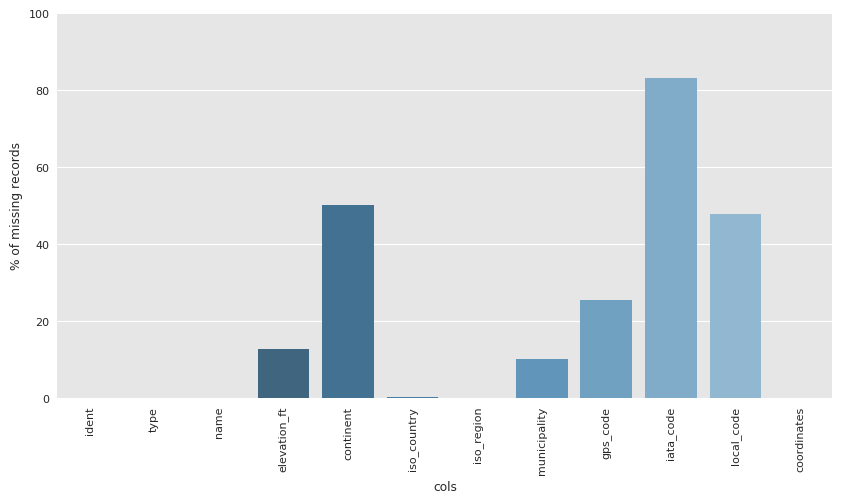

In [38]:
#visualise the missing values
assess.visualise_missing_records(airport_codes_pd)

The visual illustrates the distribution of missing data and confirms the above.

#### Cleaning Steps
Document steps necessary to clean the data

- Columns are dropped that contain over 90% missing records
- Duplicated rows will be removed

### Immigration Data

In [7]:
#Drop missing data
clean_immigration_pd = clean.remove_missing_data(immigration_pd)

Missing data is being removed...
Removal of missing data completed


In [8]:
#remove duplicated rows
clean_immigration_pd = clean.remove_duplicate_rows(clean_immigration_pd)

Removing duplicate rows...
0 rows removed.


### Temperature Data

In [9]:
#Drop missing data
clean_temperature_pd = clean.remove_missing_data(temperature_pd)

Missing data is being removed...
Removal of missing data completed


In [10]:
#remove duplicated rows
clean_temperature_pd = clean.remove_duplicate_rows(clean_temperature_pd)

Removing duplicate rows...
0 rows removed.


### Demographic Data

In [11]:
#Drop missing data
clean_demographics_pd = clean.remove_missing_data(demographics_pd)

Missing data is being removed...
Removal of missing data completed


In [12]:
#remove duplicated rows
clean_demographics_pd = clean.remove_duplicate_rows(clean_demographics_pd)

Removing duplicate rows...
0 rows removed.


### Airport Data

In [13]:
#Drop missing data
clean_airport_codes_pd = clean.remove_missing_data(airport_codes_pd)

Missing data is being removed...
Removal of missing data completed


In [14]:
#remove duplicated rows
clean_airport_codes_pd = clean.remove_duplicate_rows(clean_airport_codes_pd)

Removing duplicate rows...
0 rows removed.


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model.

Since we want to create a relational database, the star schema was chosen. The star schema is an easy to write and read format. It portrays a business's business processes and is relatively easy to query.

Since this project revolves around the immigration department, the data that is captures in this process represents the addmitance of an immigrant to the US.

Hence, the grain of the project is the addmitance of one immigrant, which equals one rows in the fact table and the corresponding dimension tables.

The dimension tables used in this project are

- dim_visa
- dim_country_temperature
- dim_tim
- dim_demographics

The fact table used is called:

- fct_immigration


![alt text](ERD.png "ERD")

#### 3.2 Mapping Out Data Pipelines
- data is loaded into staging tables
- create both dimension and fact tables
- data is written into parquet files
- final and last step are the data quality checks

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

##### Immigration Data

In [15]:
#create immigration schema
immigration_schema = schema.create_immigration_schema(clean_immigration_pd, spark)

immigration schema created


##### Temperature Data

In [16]:
#create temperature schema
temperature_schema = schema.create_temperature_schema(clean_temperature_pd, spark)

temperature schema created


##### Demographics Data

In [17]:
#create demographics schema
demographics_schema = schema.create_demographics_schema(clean_demographics_pd, spark)

demographics schema created


##### Airport Data

In [18]:
#create airport_codes schema
airport_codes_schema = schema.create_airport_schema(clean_airport_codes_pd, spark)

airport schema created


In [19]:
#create an output path for the parquet files
output_data = "tables/"

In [20]:
#read country_code custom file
country_spark = spark.read.csv("i94res_country.csv", header=True, inferSchema=True)

##### dim_visa

In [21]:
#create dim_visa table for analysis
dim_visa = tables.dim_visa(immigration_schema, output_data)

visa table created


##### dim_demographics

In [22]:
#create dim_demographics table for analysis
dim_demographics = tables.dim_demographics(demographics_schema, output_data)

demographics table created


In [48]:
dim_demographics.toPandas().head(5)

,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code
0,33.799999,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD
1,41.000000,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA
2,38.500000,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL
3,34.500000,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA
4,34.599998,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ


##### dim_time

In [23]:
#create dim_time table for analysis
dim_time = tables.dim_time(immigration_schema, output_data)

time table created


##### dim country_temperature

In [24]:
#create country_temperature table for analysis
dim_country_temperature = tables.create_country_temperature(temperature_schema, country_spark, output_data)

country_temperature table created


##### fct_immigration

In [25]:
#create fact table table for analysis
fct_immigration = tables.create_immigration_fact(immigration_schema, dim_visa, dim_time, dim_demographics, dim_country_temperature, output_data, spark)

fact immigration table created


#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [26]:
#Quality check of data
table_dfs = {
    'fct_immigration': fct_immigration,
    'dim_visa': dim_visa,
    'dim_demographics': dim_demographics,
    'dim_time': dim_time,
    'dim_country_temperature': dim_country_temperature
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    tables.checks(table_df, table_name)

Qualify check has passed for fct_immigration with 10,000 values.
Qualify check has passed for dim_visa with 115 values.
Qualify check has passed for dim_demographics with 2,891 values.
Qualify check has passed for dim_time with 3 values.
Qualify check has passed for dim_country_temperature with 289 values.


##### duplicate check for dim_country_temperature

In [42]:
dim_country_temperature.groupby("temperature_id") \
     .count() \
     .where("count > 1") \
     .drop("count").show()

+--------------+
|temperature_id|
+--------------+
|          null|
+--------------+



null as duplicate is expected, since temperature and country were joined via a 'full outer join'

##### duplicate check for fct_immigration

In [43]:
fct_immigration.groupby("cicid") \
     .count() \
     .where("count > 1") \
     .drop("count").show()

+-----+
|cicid|
+-----+
+-----+



##### duplicate check for dim_visa

In [44]:
dim_visa.groupby("visa_id") \
     .count() \
     .where("count > 1") \
     .drop("count").show()

+-------+
|visa_id|
+-------+
+-------+



##### duplicate check for dim_demographics

In [53]:
dim_demographics.groupby("id") \
     .count() \
     .where("count > 1") \
     .drop("count").show()

+---+
| id|
+---+
+---+



##### duplicate check for dim_time

In [54]:
dim_time.groupby("arrdate") \
     .count() \
     .where("count > 1") \
     .drop("count").show()

+-------+
|arrdate|
+-------+
+-------+



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Data Dictionary

* dim_time 

Feature                       |Description
:-----------------------------|:-----------
arrdate                       |primary key - arrival date in the US
arrival_date            |Arrival Date in the US
day |the day on which an immigrant arrived
week                          |the week on which an immigrant arrived
weekday                       |the weekday on which an immigrant arrived
month                      |the month on which an immigrant arrived
year                     |the year on which an immigrant arrived


* dim_demographics

Feature                       |Description
:-----------------------------|:-----------
id                       |primary key
median_age            |median age of population
male_population |number of males in the city
female_population     |number of females in the city
total_population           |total population in the city
number_of_veterans       |the number of veterans in a city
foreign_born    |number of residents that are foreign
average_household_size    |average household size
state_code    |the code of the respective state

* dim_visa

Feature                       |Description
:-----------------------------|:-----------
visa_id            |primary key
i94visa            |three categories of visa codes
visatype |class of admission
visapost     |where visa was issued

* fct_immigration

Feature                       |Description
:-----------------------------|:-----------
cicid              |primary key
i94res            |code for country of residence
depdate |departe date from the US
i94mode     |transportation mode
i94port           |the port at which an immigrant was admitted
i94cit       |code for country an immigrant was born
i94addr    |arrival state in US
airline    |airline with which arrived in US
entdepa    |admitted to US
entdepd    |departed from US
visa_id    |foreign key
temperature_id    |foreign key
arrdate    |foreign key and arrival date
state_code    |foreign key and the state code
gender    |gender
admnum    |number of admission
dtaddto    |date of admission to US
biryear    |birthyear

* dim_country_temperature

Feature                       |Description
:-----------------------------|:-----------
code            |country code for immigration country
name            |country name
temperature_id |primary key
average_temperature     |the average temperature
average_temperature_uncertainty     |confidence interval of average temperature

#### Step 5: Complete Project Write Up

* Clearly state the rationale for the choice of tools and technologies for the project.

The two main tools that were applied are

- spark
- pandas

Spark is very handy for wranging and handling big data. 
Pandas was used for data exploration and assessment. Pandas's library is not only convenient, but very handy when it comes to assessing data

Furtermore matplot lib was used for visualisation purposes.

* Propose how often the data should be updated and why

Since the immigration data set is updated monthly, an ETL pipeline that ingests and loads monthly would be appropriate.


* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x
 
 
 If the amount of data was increased by 100 times, then warehousing technology would have to come into play such as Amazon Redshift, Snowflake amongst other. Worker nodes would be required to parallelise the work and make it processable. 

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 
 
 As briefly mentioned above, an ETL pipeline can be put in place that regularly ingests and loads the data from the source to our warehouse. Such an ETL pipeline could be created in Apache Airflow. Nowadays, there are many third-party systems available that do that on your behalf as well. The ETL pipeline can be configured to run every day at 7am. 

* Write a description of how you would approach the problem differently under the following scenarios:
 * The database needed to be accessed by 100+ people
 
 
 Again, if we have to scale up, big data technologies like Amazon Redshift or Snowflake have to be implemented. These technologies are designed to handle a huge volumne of requests. They are easily scalable and easy to handle if the amount of people working with data is increasing.

In [ ]:
#create views for analysis
fct_immigration = fct_immigration.createOrReplaceTempView("fct_immigration")
dim_country_temperature = dim_country_temperature.createOrReplaceTempView("dim_country_temperature")
dim_time = dim_time.createOrReplaceTempView("dim_time")
dim_demographics = dim_demographics.createOrReplaceTempView("dim_demographics")
dim_visa = dim_visa.createOrReplaceTempView("dim_visa")


In [70]:
#query example
spark.sql("""
SELECT 
    count(demographics.foreign_born) as foreign_count,
    demographics.foreign_born as foreign_born,
    country_temperature.name as city,
    fact.biryear as biryear
FROM fct_immigration as fact
LEFT JOIN dim_demographics as demographics
    ON demographics.state_code = fact.i94addr
FULL JOIN dim_country_temperature as country_temperature
    ON country_temperature.code = fact.i94res
GROUP BY foreign_born, city, biryear
ORDER BY foreign_count DESC

""").show()

+-------------+------------+------+-------+
|foreign_count|foreign_born|  city|biryear|
+-------------+------------+------+-------+
|          320|   3212500.0|FRANCE| 1998.0|
|          320|     10961.0|FRANCE| 1998.0|
|          320|     23777.0|FRANCE| 1998.0|
|          320|     17733.0|FRANCE| 1998.0|
|          320|     27058.0|FRANCE| 1998.0|
|          320|     24630.0|FRANCE| 1998.0|
|          320|     17735.0|FRANCE| 1998.0|
|          320|     61247.0|FRANCE| 1998.0|
|          320|     11948.0|FRANCE| 1998.0|
|          320|     26960.0|FRANCE| 1998.0|
|          305|     61247.0|FRANCE| 1977.0|
|          305|     11948.0|FRANCE| 1977.0|
|          305|     27058.0|FRANCE| 1977.0|
|          305|     10961.0|FRANCE| 1977.0|
|          305|     17733.0|FRANCE| 1977.0|
|          305|   3212500.0|FRANCE| 1977.0|
|          305|     26960.0|FRANCE| 1977.0|
|          305|     17735.0|FRANCE| 1977.0|
|          305|     24630.0|FRANCE| 1977.0|
|          305|     23777.0|FRAN